# 작사가 인공지능 만들기


### Step 1. 데이터 다운로드   
Song Lyrics 파일 다운로드    

$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip   

$ unzip song_lyrics.zip -d ~/aiffel/lyricist/data/lyrics  #lyrics 폴더에 압축풀기

#### Step 2. 데이터 읽어오기   
glob 모듈 = txt 파일 읽어오기 
raw_corpus 리스트에 문장 단위로 저장.   
(여기서 corpus는 말뭉치로 대량의 텍스트 데이터.)

In [1]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:7])


데이터 크기: 187088
Examples:
 ['I bought my first key from my baby momma brother', 'I bought my first key', 'Bought my bought my first key', 'I bought my first key from my baby momma brother', 'I bought my first key', 'Bought my bought my first key', 'Yeah hustling on my city streets']


* 우리가 원하는 문장 길이 정하기

In [2]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

I bought my first key from my baby momma brother
I bought my first key
Bought my bought my first key
I bought my first key from my baby momma brother
I bought my first key
Bought my bought my first key
Yeah hustling on my city streets
Trying to get a whole key i bought my frist key my first key
Inand we was getting em like for twenty five
Colombian connect homey we was getting fly


* 프로젝트로 사용할 라이브러리 불러오기 & 파일의 내용 확인 

### Step 3. 데이터 정제   
: 문장 생성에 적합한 모양으로 데이터 정제하기.   
preprocess_setence() 함수로 정제.   
* 지나치게 긴 문장은 과도한 padding으로 제거. 적당하게 긴 문장으로 설정하기 위해 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습데이터에서 제외하기를 권함.   


In [3]:
#정제 데이터 만들기 
#정제 데이터란? : 데이터 분석에 앞서 전처리가 완료된 데이터. 빈 값/ 정상 범위 벗어난 값 제거하거나 다른 값으로 대체하는 작업. 


import re                  # 정규표현식을 위한 Regex 지원 모듈 (문장 데이터를 정돈하기 위해) 
import numpy as np         # 변환된 문장 데이터(행렬)을 편하게 처리하기 위해
import tensorflow as tf    # 대망의 텐서플로우!

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))   # 이 문장이 어떻게 필터링되는지 확인해 보세요.

<start> this is sample sentence . <end>


### Step 4. 평가 데이터셋 분리   
훈련 데이터와 평가 데이터를 분리. 
* tokenize() 로 데이터 -> tensor로 변환    
* sklearn > train_test_split()로 훈련 데이터 & 평가데이터 분리   
   
* 단어장의 크기는 12,000이상으로 설정.   
* 총 데이터의 20%를 평가 데이터셋으로 사용.   


<학습 포인트> 
* 정규표현식을 이용한 corpus 생성   
* tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환   
* tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환   
* dataset을 얻음으로써 데이터 다듬기 과정은 끝났습니다. tf.data.Dataset에서 제공하는 shuffle(), batch() 등 다양한 데이터셋 관련 기능을 손쉽게 이용할 수 있게 되었군요.
   
    -> 이 모든 일련의 과정을 텐서플로우에서의 데이터 전처리 라고 함! 

In [4]:

corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue #빈 문장은 제거 작업
    if sentence[-1] == ":": continue #":"로 마지막에 끝나는 문장 넘기기 ?
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:3]

['<start> i bought my first key from my baby momma brother <end>',
 '<start> i bought my first key <end>',
 '<start> bought my bought my first key <end>']

In [28]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,  # 전체 단어의 개수 #[중요] 단어장 수를 12000개로 맞추니 Memory 때문에 오류가 생겨서 7000으로 맞추고 했습니다ㅠㅠ
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   5 631 ...   0   0   0]
 [  2   5 631 ...   0   0   0]
 [  2 631  13 ...   0   0   0]
 ...
 [  2  45 900 ...   0   0   0]
 [  2  45  66 ...   0   0   0]
 [  2   8  83 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f20a58e80d0>


In [29]:
#생성된 데이터 3번째 행, 10번째 열까지 출력해보기 
print(tensor[:3, :10])

[[  2   5 631  13 241 749  74  13  51 723]
 [  2   5 631  13 241 749   3   0   0   0]
 [  2 631  13 631  13 241 749   3   0   0]]


In [54]:
# 총 test data의 20퍼센트를 test train에 설정 
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=42)

In [56]:
#위에 split한 값 빼보기 
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (140599, 346)
Target Train: (140599, 346)


In [30]:
#tokenizer에 구축된 단어 사전의 인덱스로 단어 사전 어떻게 구축 되었는지 확인. 

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [31]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[  2   5 631  13 241 749  74  13  51 723 580   3   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [32]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 100
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((100, 346), (100, 346)), types: (tf.int32, tf.int32)>

### Step 5. 인공지능 만들고 평가하기  
* 모델의 Embedding size & Hidden size 조절하여 10 Epoch 안에 val_loss 값 2.2 수준으로 줄이기.    
* 멋진 모델이 생성한 가사 한 줄 제출! 

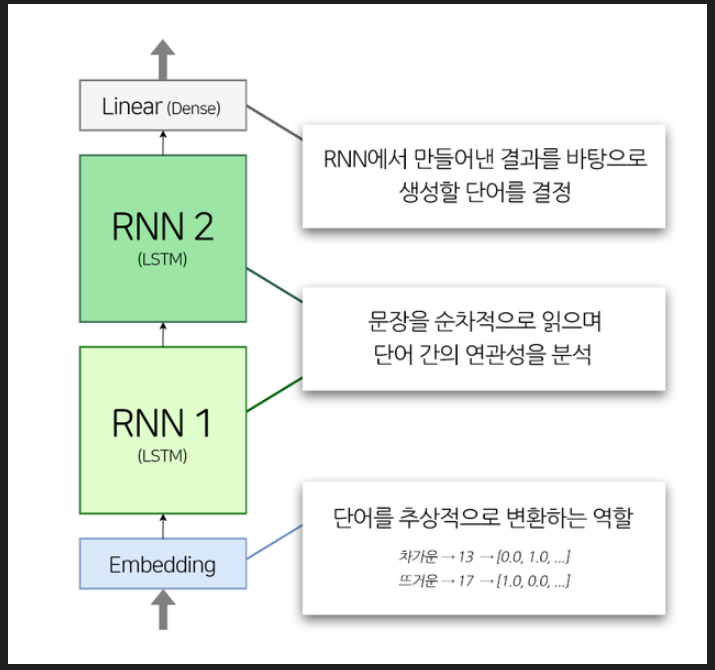

img_resize=img.resize((250,250))

In [33]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 120
hidden_size = 500
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [34]:
#모델 샘플로 데이터셋의 첫번째 가져와보기 
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(100, 346, 7001), dtype=float32, numpy=
array([[[ 8.64108151e-05, -4.16129915e-04, -1.00909834e-04, ...,
          2.96470709e-04,  3.92844813e-05, -2.67849373e-05],
        [ 1.78594797e-04, -4.51237720e-04, -2.56500440e-04, ...,
          3.69055750e-04, -8.17267282e-05, -1.70324027e-04],
        [ 2.09220816e-04, -3.24247259e-04, -3.28950497e-04, ...,
          2.87426839e-04, -3.13361379e-04, -3.12414340e-04],
        ...,
        [ 9.38602490e-04, -1.95777696e-03, -6.87143474e-04, ...,
         -7.77028501e-04,  1.10865221e-03, -3.32603347e-03],
        [ 9.38602490e-04, -1.95777719e-03, -6.87143474e-04, ...,
         -7.77028268e-04,  1.10865198e-03, -3.32603324e-03],
        [ 9.38602025e-04, -1.95777789e-03, -6.87143649e-04, ...,
         -7.77028443e-04,  1.10865233e-03, -3.32603324e-03]],

       [[ 8.64108151e-05, -4.16129915e-04, -1.00909834e-04, ...,
          2.96470709e-04,  3.92844813e-05, -2.67849373e-05],
        [ 1.78594797e-04, -4.51237720e-04, -2

In [35]:
model.summary()

Model: "text_generator_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  840120    
_________________________________________________________________
lstm_6 (LSTM)                multiple                  1242000   
_________________________________________________________________
lstm_7 (LSTM)                multiple                  2002000   
_________________________________________________________________
dense_3 (Dense)              multiple                  3507501   
Total params: 7,591,621
Trainable params: 7,591,621
Non-trainable params: 0
_________________________________________________________________


In [14]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he win win world world holdin fun fun fun fun fun grown read read thank thank thank thank fancy '

In [43]:
#혹시 모르니 GPU가 제대로 작동하는지 확인.. 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

----> 이제 모델 학습 준비 완료!   
Adam! Optimize하고 학습 시작하렴    


In [41]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=10)

Epoch 1/10
1757/1757 [==============================] - 685s 390ms/step - loss: 0.1413
Epoch 2/10
1757/1757 [==============================] - 679s 386ms/step - loss: 0.1236
Epoch 3/10
1757/1757 [==============================] - 688s 391ms/step - loss: 0.1154
Epoch 4/10
1757/1757 [==============================] - 676s 385ms/step - loss: 0.1089
Epoch 5/10
1757/1757 [==============================] - 676s 385ms/step - loss: 0.1035
Epoch 6/10
1757/1757 [==============================] - 721s 410ms/step - loss: 0.0987
Epoch 7/10
1757/1757 [==============================] - 666s 379ms/step - loss: 0.0942
Epoch 8/10
1757/1757 [==============================] - 672s 382ms/step - loss: 0.0900
Epoch 9/10
1757/1757 [==============================] - 670s 381ms/step - loss: 0.0861
Epoch 10/10
1757/1757 [==============================] - 680s 387ms/step - loss: 0.0826


In [46]:
# 평가하기 부분 
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
																 tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [67]:
generate_text(model, tokenizer, init_sentence="<start> love")

'<start> love is a beautiful thing <end> '

* 프로젝트 소감:   
위에 데이터셋의 test 부분을 20% 정하는 부분에서 어떠한 영향을 주는지에 대한 감은 아직 없지만, 
아주 흥미로운 프로젝트 였습니다.
   
   추가적으로 한 가수/작곡가만의 노래를 넣어서 새로운 가사를 만들어 보는 것도 재미있을 것 같습니다.
   거기에다가 AI로 믹싱된 노래에 가사를 넣고 맞추는 것도 아주 흥미로운 게 될 수 있을 것 같습니다.
   
   *문제: GPU 메모리 부분에서 단어장 12,000개를 만드는데에 오류가 생겼지만, 이 부분은 추후 AI 부분에 계속 문제가 될것 같습니다.
   이러한 부분에 대한 해결책을 함께 논의 하고, 방법을 알아가는 건 아주 도움이 많이 될 것 같습니다. 

((140599, 346), (35150, 346), (140599, 346), (35150, 346))